In [ ]:
# Description: Plot Figures 6, 7, 8 (Time series of wind, tide, temperature, velocity, shear and Reynolds stresses).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        December/2020

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import Timestamp
from xarray import open_dataset, DataArray
from cmocean.cm import balance

In [3]:
def stickplot(time, u, v, **kw):
    """
    Source: https://ocefpaf.github.io/python4oceanographers/blog/2014/09/15/stick_plot/
    """
    width = kw.pop('width', 0.001)
    headwidth = kw.pop('headwidth', 0)
    headlength = kw.pop('headlength', 0)
    headaxislength = kw.pop('headaxislength', 0)
    angles = kw.pop('angles', 'uv')
    ax = kw.pop('ax', None)

    if angles != 'uv':
        raise AssertionError("Stickplot angles must be 'uv' so that"
                             "if *U*==*V* the angle of the arrow on"
                             "the plot is 45 degrees CCW from the *x*-axis.")

    # time, u, v = map(np.asanyarray, (time, u, v))
    if not ax:
        fig, ax = plt.subplots()

    q = ax.quiver(time, np.zeros(time.size), u, v,
                  angles='uv', width=width, headwidth=headwidth,
                  headlength=headlength, headaxislength=headaxislength,
                  **kw)

    ax.yaxis.set_tick_params(labelleft=False)
    ax.yaxis.set_tick_params(width=0)
    ax.xaxis_date()

    return q

In [4]:
plt.close('all')

head = "../../data_reproduce_figs/"

fname = 'OC40S-Ad2rs5-10min_ensembles-nobinmap-bias-corrected.nc'
finT = "OC40S-T.nc"

################################
enslen_min = 20
################################

WHITE_BBOX = True
LONG_LABEL = True

vmau = 0.4
vmauz = 0.05
vmauw = 1.0
rho = 1024 # [kg/m3]
tempmin, tempmax = 12, 16

H = 40
fs = 1

# tl, tr = '2017-09-15 20:00:00', '2017-09-16 10:00:00' # Persistent southward flow (OC25SA depl 1)
# tl, tr = '2017-09-15 22:00:00', '2017-09-16 13:00:00' # Persistent southward flow (OC40S depl 1)
# tl, tr = '2017-10-15 12:00:00', '2017-10-17 00:00:00' # Persistent northward flow (OC40S depl 2)
# tl, tr = '2017-10-21 06:00:00', '2017-10-22 14:00:00' # Persistent southward flow (OC40S depl 2)

tl, tr = '2017-01-01 20:00:00', '2017-12-31 00:00:00'
zlo, zhi = 0, 30

In [5]:
wwt = open_dataset(head+'windstress-wave-tide.nc')
wwt2 = open_dataset(head+'windstress-SIOMiniMETBuoy.nc')
T = open_dataset(head+finT)['T']

ds = open_dataset(head+fname)

ds = ds.sel(dict(t=slice(tl, tr)))
ds = ds.sel(dict(z=slice(zlo, zhi)))

T = T.sel(dict(t=slice(tl, tr)))
T = T.interpolate_na(dim='z').interpolate_na(dim='t')
T['z'] = H - T['z'] # Depth to height above bottom.
tT = T['t'].values
zT = T['z'].values

In [6]:
ds = ds.resample(dict(t='%d min'%enslen_min)).mean(dim='t')
t, z, u, v, uz, vz = ds['t'].values, ds['z'].values, ds['u'].values, ds['v'].values, ds['uz'].values, ds['vz'].values
uw, vw = ds['uw'].values, ds['vw'].values

In [7]:
# Mask out Reynolds stress values that are smaller than the
# Williams & Simpson (2004) minimum measurable value.

moor = fname.split('/')[-1].split('-')[0]
dnoise = np.load(head+"noise_%s.npz"%moor)
Nb, Nb5 = dnoise["Nb"].flatten()[0], dnoise["Nb5"].flatten()[0]
spstd = np.maximum(Nb, Nb5) # Conservative estimate, use the highest noise between the Janus beams and the vertical beam.

theta = 25
d2r = np.pi/180
M = fs*60*enslen_min
minRS = spstd**2/(np.sqrt(M)*np.sin(2*theta*d2r)) # Williams & Simpson (2004).

uw[np.abs(uw)<minRS] = np.nan
vw[np.abs(vw)<minRS] = np.nan

<ipython-input-8-ff09a39b2fce>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs3 = ax3.pcolormesh(tT, zT, T, vmin=tempmin, vmax=tempmax, cmap=plt.cm.coolwarm)
<ipython-input-8-ff09a39b2fce>:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cs4 = ax4.pcolormesh(t, z, u.T, vmin=-vmau, vmax=vmau, cmap=balance)
<ipython-input-8-ff09a39b2fce>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  

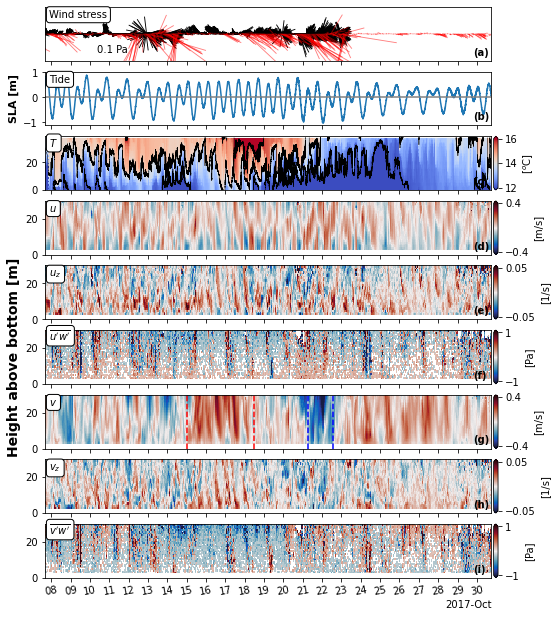

In [8]:
# Plotting.

figsize = (8, 10.5)
fig, ax = plt.subplots(nrows=9, sharex=True, figsize=figsize)
ax1, ax2, ax3, ax4, ax5 = ax[0], ax[1], ax[2], ax[3], ax[4]
ax6, ax7, ax8, ax9 = ax[5], ax[6], ax[7], ax[8]

ttide = wwt['ttide'].values
ax2.plot(ttide, wwt['tide'].values - wwt['tide'].mean().values)

# Wind from Guadalupe APL station (closest to moorings).
twind = wwt['twind'].values
taux, tauy = wwt['taux'].values, wwt['tauy'].values
q = stickplot(twind, taux, tauy, ax=ax1, scale=3, width=0.002)
xq, yq = 0.1, 0.2
ax1.quiverkey(q, xq, yq, 0.1, r"0.1 Pa", coordinates="axes", labelpos="E")

# Wind from SIO MiniMET buoy (record goes into November, but not close to moorings).
twind = wwt2['t'].values
taux, tauy = wwt2['taux'].values, wwt2['tauy'].values
_ = stickplot(twind, taux, tauy, ax=ax1, scale=3, width=0.002, color='red', alpha=0.5)

cs3 = ax3.pcolormesh(tT, zT, T, vmin=tempmin, vmax=tempmax, cmap=plt.cm.coolwarm)
cc3 = ax3.contour(tT, zT, T, levels=np.arange(tempmin, tempmax+2, 2), colors='k', linewidths=0.5)
cs4 = ax4.pcolormesh(t, z, u.T, vmin=-vmau, vmax=vmau, cmap=balance)
cs5 = ax5.pcolormesh(t, z, uz.T, vmin=-vmauz, vmax=vmauz, cmap=balance)
cs6 = ax6.pcolormesh(t, z, uw.T*rho, vmin=-vmauw, vmax=vmauw, cmap=balance)
cs7 = ax7.pcolormesh(t, z, v.T, vmin=-vmau, vmax=vmau, cmap=balance)
cs8 = ax8.pcolormesh(t, z, vz.T, vmin=-vmauz, vmax=vmauz, cmap=balance)
cs9 = ax9.pcolormesh(t, z, vw.T*rho, vmin=-vmauw, vmax=vmauw, cmap=balance)

yli = (0, 30)
ax4.set_ylim(yli)
ax5.set_ylim(yli)
ax6.set_ylim(yli)
ax7.set_ylim(yli)
ax8.set_ylim(yli)
ax9.set_ylim(yli)

cbaxpos = [1.005, 0, 0.01, 1]
tickrot = 0

cbax3 = ax3.inset_axes(cbaxpos)
cb3 = fig.colorbar(cs3, cax=cbax3, extend="both")
cb3.set_ticks([tempmin, int(0.5*(tempmin+tempmax)), tempmax])
cb3.set_label(r"[$^o$C]")

tickrot = 0
cbax4 = ax4.inset_axes(cbaxpos)
cb4 = fig.colorbar(cs4, cax=cbax4, extend="both")
cb4.set_ticks([-vmau, vmau])
cb4.ax.yaxis.set_tick_params(rotation=tickrot)
cb4.set_label(r"[m/s]")

tickrot = 0
cbax5 = ax5.inset_axes(cbaxpos)
cb5 = fig.colorbar(cs5, cax=cbax5, extend="both")
cb5.set_ticks([-vmauz, vmauz])
cb5.ax.yaxis.set_tick_params(rotation=tickrot)
cb5.set_label(r"[1/s]")

cbax6 = ax6.inset_axes(cbaxpos)
cb6 = fig.colorbar(cs6, cax=cbax6, extend="both")
cb6.set_ticks([-vmauw, vmauw])
cb6.ax.yaxis.set_tick_params(rotation=tickrot)
cb6.set_label(r"[Pa]")

cbax7 = ax7.inset_axes(cbaxpos)
cb7 = fig.colorbar(cs7, cax=cbax7, extend="both")
cb7.set_ticks([-vmau, vmau])
cb7.ax.yaxis.set_tick_params(rotation=tickrot)
cb7.set_label(r"[m/s]")

tickrot = 0
cbax8 = ax8.inset_axes(cbaxpos)
cb8 = fig.colorbar(cs8, cax=cbax8, extend="both")
cb8.set_ticks([-vmauz, vmauz])
cb8.ax.yaxis.set_tick_params(rotation=tickrot)
cb8.set_label(r"[1/s]")

cbax9 = ax9.inset_axes(cbaxpos)
cb9 = fig.colorbar(cs9, cax=cbax9, extend="both")
cb9.set_ticks([-vmauw, vmauw])
cb9.ax.yaxis.set_tick_params(rotation=tickrot)
cb9.set_label(r"[Pa]")


ax2.set_ylabel(r"SLA [m]", fontsize=11, fontweight='black')
ax2.axhline(color='gray')

bb = dict(boxstyle='round', ec='k', fc='w')
xt, yt = 0.01, 0.8
ax2.text(xt, yt, r"Tide", transform=ax2.transAxes, bbox=bb)
ax1.text(xt, yt, r"Wind stress", transform=ax1.transAxes, bbox=bb)
ax3.text(xt, yt, r"$T$", transform=ax3.transAxes, bbox=bb)
ax4.text(xt, yt, r"$u$", transform=ax4.transAxes, bbox=bb)
ax5.text(xt, yt, r"$u_z$", transform=ax5.transAxes, bbox=bb)
ax6.text(xt, yt, r"$\overline{u'w'}$", transform=ax6.transAxes, bbox=bb)
ax7.text(xt, yt, r"$v$", transform=ax7.transAxes, bbox=bb)
ax8.text(xt, yt, r"$v_z$", transform=ax8.transAxes, bbox=bb)
ax9.text(xt, yt, r"$\overline{v'w'}$", transform=ax9.transAxes, bbox=bb)

xt, yt = 0.96, 0.1
ax1.text(xt, yt, r"(a)", fontweight='black', transform=ax1.transAxes)
ax2.text(xt, yt, r"(b)", fontweight='black', transform=ax2.transAxes)
ax3.text(xt, yt, r"(c)", fontweight='black', transform=ax3.transAxes)
ax4.text(xt, yt, r"(d)", fontweight='black', transform=ax4.transAxes)
ax5.text(xt, yt, r"(e)", fontweight='black', transform=ax5.transAxes)
ax6.text(xt, yt, r"(f)", fontweight='black', transform=ax6.transAxes)
ax7.text(xt, yt, r"(g)", fontweight='black', transform=ax7.transAxes)
ax8.text(xt, yt, r"(h)", fontweight='black', transform=ax8.transAxes)
ax9.text(xt, yt, r"(i)", fontweight='black', transform=ax9.transAxes)

ax6.set_ylabel(r"Height above bottom [m]", fontsize=14, fontweight='black')

tl, tr = Timestamp("2017-10-07 16:00:00"), Timestamp("2017-10-30 18:00:00")
ax9.set_xlim(tl, tr)

plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)
plt.setp(ax7.get_xticklabels(), visible=False)
plt.setp(ax8.get_xticklabels(), visible=False)
ax9.xaxis.set_tick_params(rotation=10)

tln, trn = Timestamp('2017-10-15 00:00:00'), Timestamp('2017-10-18 12:00:00') # Persistent northward flow (OC40S depl 2)
tls, trs = Timestamp('2017-10-21 06:00:00'), Timestamp('2017-10-22 14:00:00') # Persistent southward flow (OC40S depl 2)

l1 = ax7.axvline(tln, color='r', linestyle='--')
l2 = ax7.axvline(trn, color='r', linestyle='--')
l3 = ax7.axvline(tls, color='b', linestyle='--')
l4 = ax7.axvline(trs, color='b', linestyle='--')

locator = mdates.AutoDateLocator(minticks=12, maxticks=24)
formatter = mdates.ConciseDateFormatter(locator)
ax9.xaxis.set_major_locator(locator)
ax9.xaxis.set_major_formatter(formatter)

In [9]:
fig.savefig("fig06.png", dpi=300, bbox_inches="tight")
plt.show()

In [10]:
tempannot = np.arange(tempmin, tempmax+2, 2)
ax4.contour(tT, zT, T, levels=tempannot, colors='k', linewidths=0.5)
ax5.contour(tT, zT, T, levels=tempannot, colors='k', linewidths=0.5)
ax6.contour(tT, zT, T, levels=tempannot, colors='k', linewidths=0.5)
ax7.contour(tT, zT, T, levels=tempannot, colors='k', linewidths=0.5)
ax8.contour(tT, zT, T, levels=tempannot, colors='k', linewidths=0.5)
ax9.contour(tT, zT, T, levels=tempannot, colors='k', linewidths=0.5)

locator = mdates.AutoDateLocator(minticks=10, maxticks=16)
fmts = ['', '%Y', '%Y', '%Y', '%Y', '%Y %H:%M']
formatter = mdates.ConciseDateFormatter(locator, offset_formats=fmts)
ax9.xaxis.set_major_locator(locator)
ax9.xaxis.set_major_formatter(formatter)

l1.set_visible(False)
l2.set_visible(False)
l3.set_visible(False)
l4.set_visible(False)

tbores1l, tbores1r = Timestamp("2017-10-15 00:00:00"), Timestamp("2017-10-15 12:00:00")
tbores2l, tbores2r = Timestamp("2017-10-16 00:00:00"), Timestamp("2017-10-16 12:00:00")
tbores3l, tbores3r = Timestamp("2017-10-17 00:00:00"), Timestamp("2017-10-17 12:00:00")
tbores4l, tbores4r = Timestamp("2017-10-18 00:00:00"), Timestamp("2017-10-18 12:00:00")
tshearsouthl, tshearsouthr = Timestamp("2017-10-22 01:00:00"), Timestamp("2017-10-22 11:00:00")

ax6.axvline(tbores1l, color='r', linestyle='--')
ax6.axvline(tbores1r, color='r', linestyle='--')
ax6.axvline(tbores2l, color='r', linestyle='--')
ax6.axvline(tbores2r, color='r', linestyle='--')
ax6.axvline(tbores3l, color='r', linestyle='--')
ax6.axvline(tbores3r, color='r', linestyle='--')
ax6.axvline(tbores4l, color='r', linestyle='--')
ax6.axvline(tbores4r, color='r', linestyle='--')
ax9.axvline(tbores1l, color='r', linestyle='--')
ax9.axvline(tbores1r, color='r', linestyle='--')
ax9.axvline(tbores2l, color='r', linestyle='--')
ax9.axvline(tbores2r, color='r', linestyle='--')
ax9.axvline(tbores3l, color='r', linestyle='--')
ax9.axvline(tbores3r, color='r', linestyle='--')
ax9.axvline(tbores4l, color='r', linestyle='--')
ax9.axvline(tbores4r, color='r', linestyle='--')

ax6.plot([tbores1l, tbores1r], [0, 0], color='r', linewidth=5.0)
ax6.plot([tbores2l, tbores2r], [0, 0], color='r', linewidth=5.0)
ax6.plot([tbores3l, tbores3r], [0, 0], color='r', linewidth=5.0)
ax6.plot([tbores4l, tbores4r], [0, 0], color='r', linewidth=5.0)
ax9.plot([tbores1l, tbores1r], [0, 0], color='r', linewidth=5.0)
ax9.plot([tbores2l, tbores2r], [0, 0], color='r', linewidth=5.0)
ax9.plot([tbores3l, tbores3r], [0, 0], color='r', linewidth=5.0)
ax9.plot([tbores4l, tbores4r], [0, 0], color='r', linewidth=5.0)

ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
ax5.set_ylim(bottom=0)
ax6.set_ylim(bottom=0)
ax7.set_ylim(bottom=0)
ax8.set_ylim(bottom=0)
ax9.set_ylim(bottom=0)

(0.0, 30.0)

In [11]:
ax9.set_xlim(tln, trn) # Zoom in on relaxation event, northward sheared flow.
plt.show()

In [12]:
fig.savefig("fig07.png", dpi=300, bbox_inches="tight")

In [13]:
ax6.axvline(tshearsouthl, color='b', linestyle='--')
ax6.axvline(tshearsouthr, color='b', linestyle='--')
ax9.axvline(tshearsouthl, color='b', linestyle='--')
ax9.axvline(tshearsouthr, color='b', linestyle='--')

ax6.plot([tshearsouthl, tshearsouthr], [0, 0], color='b', linewidth=5.0)
ax9.plot([tshearsouthl, tshearsouthr], [0, 0], color='b', linewidth=5.0)

ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)
ax5.set_ylim(bottom=0)
ax6.set_ylim(bottom=0)
ax7.set_ylim(bottom=0)
ax8.set_ylim(bottom=0)
ax9.set_ylim(bottom=0)

(0.0, 30.0)

In [14]:
ax9.set_xlim(tls, trs) # Zoom in on southward sheared flow.
plt.show()

In [15]:
fig.savefig("fig08.png", dpi=300, bbox_inches="tight")